<a href="https://colab.research.google.com/github/linerookie/sp24f/blob/main/KWRD_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 셀 1: 패키지 설치
!pip install googletrans==4.0.0-rc1 -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.55.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.13.3 which is incompatible.
langsmith 0.4.59 requires httpx<1,>=0.23.0, but you have httpx 0.13.3 which is incompatible.
gradio 5.50.0 requires httpx<1.0,>=0.24.1, 

In [ ]:
# 셀 2: 라이브러리 임포트
import pandas as pd
from googletrans import Translator
from tqdm import tqdm
import time

translator = Translator()

In [ ]:
# 셀 3: 번역 함수
def translate_to_english(text, max_retries=3):
    if not text or pd.isna(text) or str(text).strip() == '':
        return ''

    for attempt in range(max_retries):
        try:
            result = translator.translate(str(text), src='ko', dest='en')
            return result.text
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(1)
                continue
            else:
                print(f"번역 실패: {text[:30]}... - {e}")
                return ''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 셀 4: CSV 로드 및 현황 확인
df = pd.read_csv('/content/drive/MyDrive/datathon/데이터/데이터/data_clean_v1.csv', encoding='utf-8')
empty_mask = df['NODE_TTLE_EN'].isna() | (df['NODE_TTLE_EN'] == '')
print(f"전체: {len(df):,}개 | 번역 필요: {empty_mask.sum():,}개")

전체: 6,113개 | 번역 필요: 307개


In [ ]:
# 셀 5: 번역 실행 (약 5~10분 소요)
translated_count = 0

for idx in tqdm(df[empty_mask].index, desc="번역 중"):
    korean_title = df.loc[idx, 'NODE_TTLE']

    if korean_title and str(korean_title).strip():
        translated = translate_to_english(korean_title)
        if translated:
            df.loc[idx, 'NODE_TTLE_EN'] = translated.lower()
            translated_count += 1
        time.sleep(0.5)  # API 제한 방지

print(f"✅ 번역 완료! {translated_count:,}개")

번역 중:  53%|█████▎    | 162/307 [05:33<09:46,  4.04s/it]

번역 실패: 우주에서의 일시적 오류에 대응하기 위한 비트 수준 컴파... - The read operation timed out


번역 중: 100%|██████████| 307/307 [10:49<00:00,  2.12s/it]

✅ 번역 완료! 306개


In [ ]:
# 셀 6: 결과 저장
df.to_csv('data_clean_v2.csv', index=False, encoding='utf-8')
print("💾 저장 완료: data_clean_v2.csv")

💾 저장 완료: data_clean_v2.csv


In [ ]:
# 셀 7: 파일 다운로드
from google.colab import files
files.download('data_clean_v2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 셀 1: 패키지 설치
!pip install wordcloud -q

In [ ]:
# 셀 2: 파일 업로드 후 코드 실행
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 셀 3: 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/datathon/데이터/데이터/컴퓨터학_최종키워드.csv', encoding='utf-8')
print(f"전체 논문 수: {len(df):,}개")

# 전처리
df['PBSH'] = df['PBSH'].astype(str)
df['YEAR'] = df['PBSH'].str[:4].astype(int)

def parse_keywords(kw_str):
    if pd.isna(kw_str) or kw_str == '':
        return []
    return [k.strip().lower() for k in str(kw_str).split(',') if k.strip()]

df['KEYWORD_LIST'] = df['최종 키워드'].apply(parse_keywords)
print(f"데이터 기간: {df['YEAR'].min()} ~ {df['YEAR'].max()}")

전체 논문 수: 6,086개
데이터 기간: 2021 ~ 2025


In [ ]:
# 셀 4: 전체 키워드 빈도 TOP 30
all_keywords = []
for kw_list in df['KEYWORD_LIST']:
    all_keywords.extend(kw_list)

keyword_counter = Counter(all_keywords)
print("📈 전체 키워드 TOP 30:")
for i, (kw, count) in enumerate(keyword_counter.most_common(30), 1):
    print(f"{i:2}. {kw}: {count:,}회")

📈 전체 키워드 TOP 30:
 1. deep learning: 425회
 2. machine learning: 214회
 3. artificial intelligence: 186회
 4. digital forensics: 150회
 5. metaverse: 127회
 6. ai: 101회
 7. virtual reality: 100회
 8. generative ai: 95회
 9. blockchain: 94회
10. object detection: 75회
11. natural language processing: 67회
12. iot: 61회
13. issue: 58회
14. data augmentation: 57회
15. cnn: 56회
16. anomaly detection: 55회
17. computer vision: 55회
18. topic modeling: 55회
19. covid-19: 54회
20. big data: 53회
21. reinforcement learning: 52회
22. augmented reality: 50회
23. user experience: 49회
24. convolutional neural network: 47회
25. bert: 47회
26. text mining: 46회
27. education: 43회
28. lstm: 42회
29. simulation: 38회
30. research trends: 36회


In [ ]:
# 셀 5: 연도별 키워드 빈도
yearly_keywords = {}
for year in sorted(df['YEAR'].unique()):
    year_df = df[df['YEAR'] == year]
    year_kw = []
    for kw_list in year_df['KEYWORD_LIST']:
        year_kw.extend(kw_list)
    yearly_keywords[year] = Counter(year_kw)

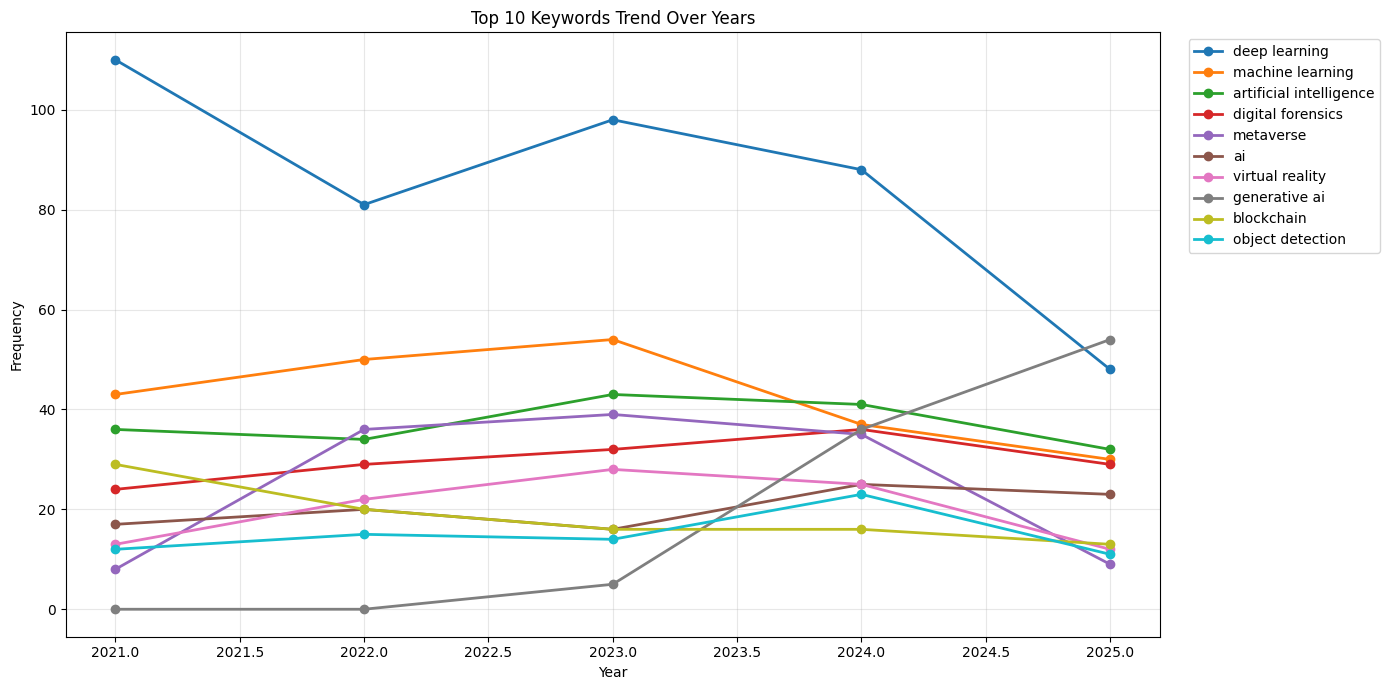

In [ ]:
# 셀 6: TOP 10 키워드 연도별 추이 시각화
top_10 = [kw for kw, _ in keyword_counter.most_common(10)]
years = sorted(yearly_keywords.keys())

plt.figure(figsize=(14, 7))
for kw in top_10:
    counts = [yearly_keywords[y].get(kw, 0) for y in years]
    plt.plot(years, counts, marker='o', linewidth=2, label=kw)

plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Top 10 Keywords Trend Over Years')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('keyword_trend.png', dpi=150)
plt.show()

In [ ]:
# 셀 7: 떠오르는 키워드 분석
years = sorted(yearly_keywords.keys())
recent_years = years[-2:]
early_years = years[:2]

growth_rates = {}
for kw in set(all_keywords):
    recent = sum(yearly_keywords[y].get(kw, 0) for y in recent_years)
    early = sum(yearly_keywords[y].get(kw, 0) for y in early_years)
    if recent >= 10:
        if early == 0:
            growth = recent * 10
        else:
            growth = (recent - early) / early * 100
        growth_rates[kw] = {'growth': growth, 'recent': recent, 'early': early}

emerging = sorted(growth_rates.items(), key=lambda x: x[1]['growth'], reverse=True)[:20]
print("🚀 떠오르는 키워드 TOP 20:")
for i, (kw, data) in enumerate(emerging, 1):
    print(f"{i:2}. {kw}: +{data['growth']:.0f}% ({data['early']} → {data['recent']})")

🚀 떠오르는 키워드 TOP 20:
 1. nursing students: +1700% (1 → 18)
 2. fine-tuning: +900% (1 → 10)
 3. generative ai: +900% (0 → 90)
 4. digital literacy: +600% (2 → 14)
 5. fuzzing: +300% (3 → 12)
 6. large language model: +280% (0 → 28)
 7. research trends: +271% (7 → 26)
 8. trends: +267% (3 → 11)
 9. multimodal: +233% (3 → 10)
10. prompt engineering: +210% (0 → 21)
11. reinforcement learning: +200% (11 → 33)
12. chatgpt: +180% (0 → 18)
13. llm: +180% (0 → 18)
14. language models: +175% (4 → 11)
15. self-supervised learning: +150% (4 → 10)
16. user experience: +150% (10 → 25)
17. cybersecurity: +150% (6 → 15)
18. transformer: +125% (8 → 18)
19. yolov8: +120% (0 → 12)
20. rag: +110% (0 → 11)


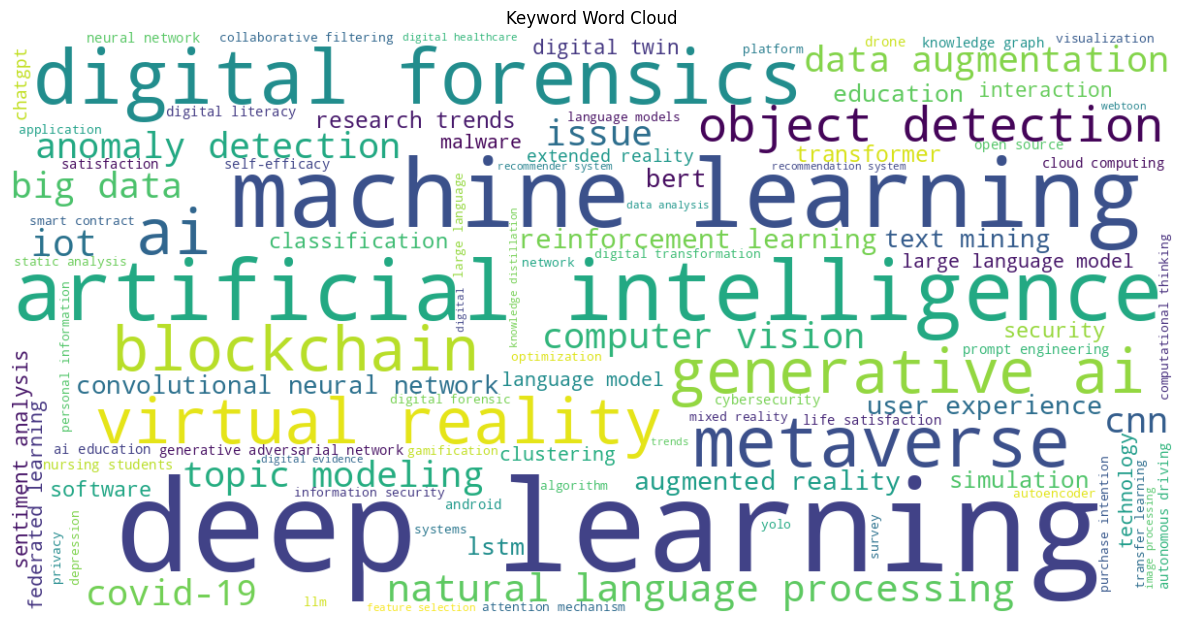

In [ ]:
# 셀 8: 워드클라우드
from wordcloud import WordCloud

wc = WordCloud(width=1200, height=600, background_color='white',
               max_words=100, colormap='viridis')
wc.generate_from_frequencies(keyword_counter)

plt.figure(figsize=(15, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Word Cloud')
plt.savefig('wordcloud.png', dpi=150)
plt.show()

📂 데이터 로딩 중...
✅ 전체 논문 수: 6,086개

📊 데이터 기간: 2021 ~ 2025
📊 뻔한 키워드 제외 후 TOP 20:
    1. digital forensics: 150회
    2. metaverse: 127회
    3. virtual reality: 100회
    4. generative ai: 95회
    5. blockchain: 94회
    6. object detection: 75회
    7. natural language processing: 67회
    8. iot: 61회
    9. issue: 58회
   10. data augmentation: 57회
   11. anomaly detection: 55회
   12. computer vision: 55회
   13. topic modeling: 55회
   14. covid-19: 54회
   15. big data: 53회
   16. reinforcement learning: 52회
   17. augmented reality: 50회
   18. user experience: 49회
   19. bert: 47회
   20. text mining: 46회

🔥 버스트 감지 - 갑자기 폭발적으로 증가한 키워드

🗓️ 2022년 버스트 키워드:
   📈 metaverse: 8 → 36회 (+350%)
   📈 anomaly detection: 4 → 13회 (+225%)
   📈 real time: 1 → 9회 (+800%)
   📈 platform: 1 → 8회 (+700%)
   📈 mobile application: 2 → 7회 (+250%)

🗓️ 2023년 버스트 키워드:
   📈 computer vision: 7 → 16회 (+129%)
   📈 user experience: 7 → 14회 (+100%)
   📈 technology: 2 → 11회 (+450%)
   🆕 autoencoder: 10회 (신규 등장!)
   📈 transformer

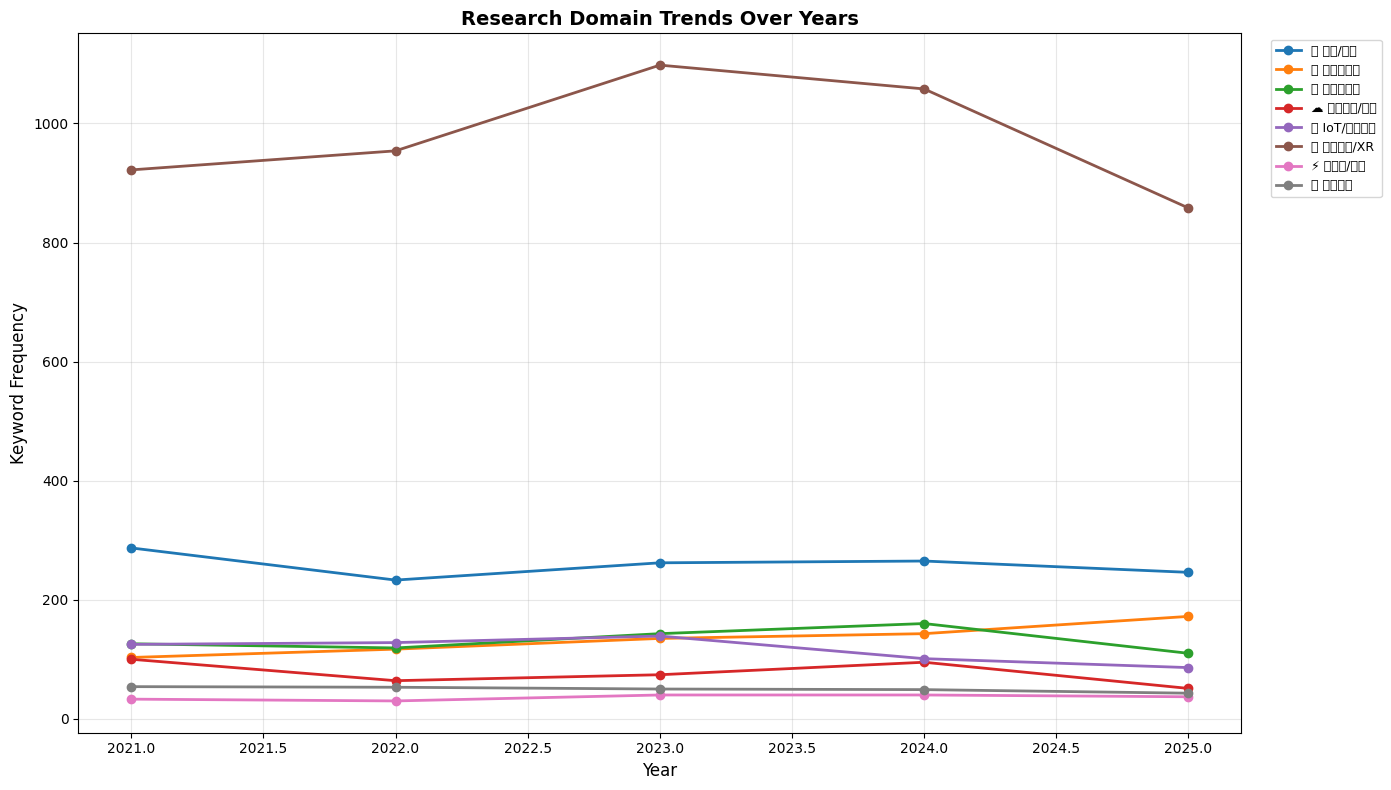

💾 저장: advanced_01_domain_trends.png


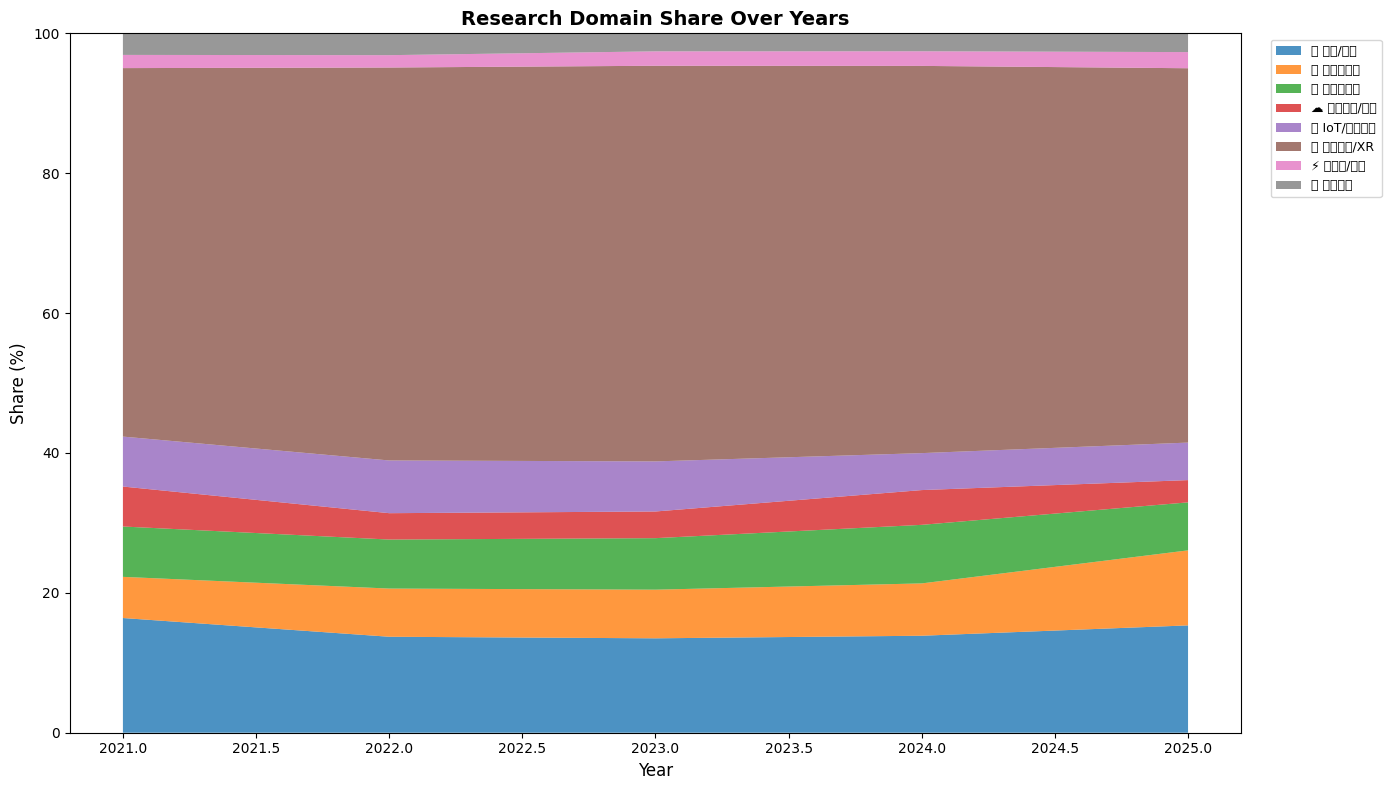

💾 저장: advanced_02_domain_share.png

🆕 연도별 '이 해의 키워드' - 그 해 처음 주목받은 키워드

🗓️ 2021년 첫 등장 주요 키워드:
   ⭐ blockchain (29회)
   ⭐ covid-19 (24회)
   ⭐ digital forensics (24회)
   ⭐ natural language processing (15회)
   ⭐ big data (14회)

🗓️ 2022년 첫 등장 주요 키워드:
   ⭐ cloud (6회)
   ⭐ software engineering (6회)
   ⭐ side-channel analysis (5회)
   ⭐ digital healthcare (5회)

🗓️ 2023년 첫 등장 주요 키워드:
   ⭐ chatgpt (8회)
   ⭐ generative ai (5회)

🗓️ 2024년 첫 등장 주요 키워드:
   ⭐ yolov8 (9회)
   ⭐ large language models (5회)
   ⭐ students (5회)

🗓️ 2025년 첫 등장 주요 키워드:
   ⭐ hallucination (5회)
   ⭐ human (5회)

🔮 다음에 뜰 키워드 예측 (최근 급성장 + 아직 소수)

🚀 주목해야 할 떠오르는 키워드:
    1. llm: 총 18회 (최근 18회, 100%)
    2. yolov8: 총 12회 (최근 12회, 100%)
    3. large language models: 총 11회 (최근 11회, 100%)
    4. rag: 총 11회 (최근 11회, 100%)
    5. large language model: 총 29회 (최근 28회, 97%)
    6. generative ai: 총 95회 (최근 90회, 95%)
    7. prompt engineering: 총 23회 (최근 21회, 91%)
    8. generative artificial intelligence: 총 11회 (최근 10회, 91%)
    9. automation: 

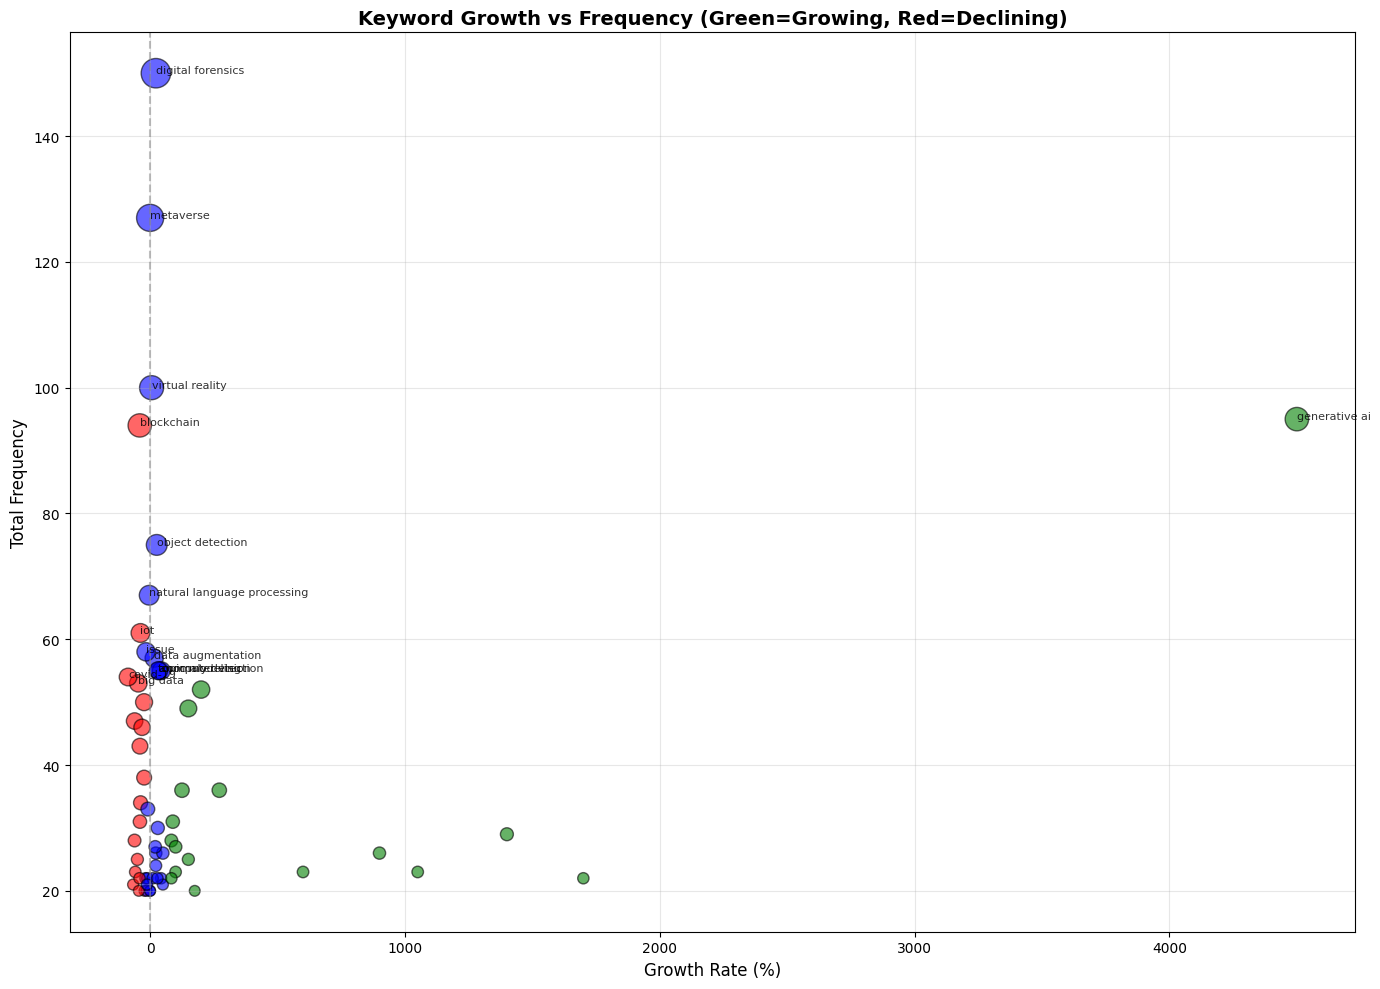

💾 저장: advanced_03_bubble_chart.png


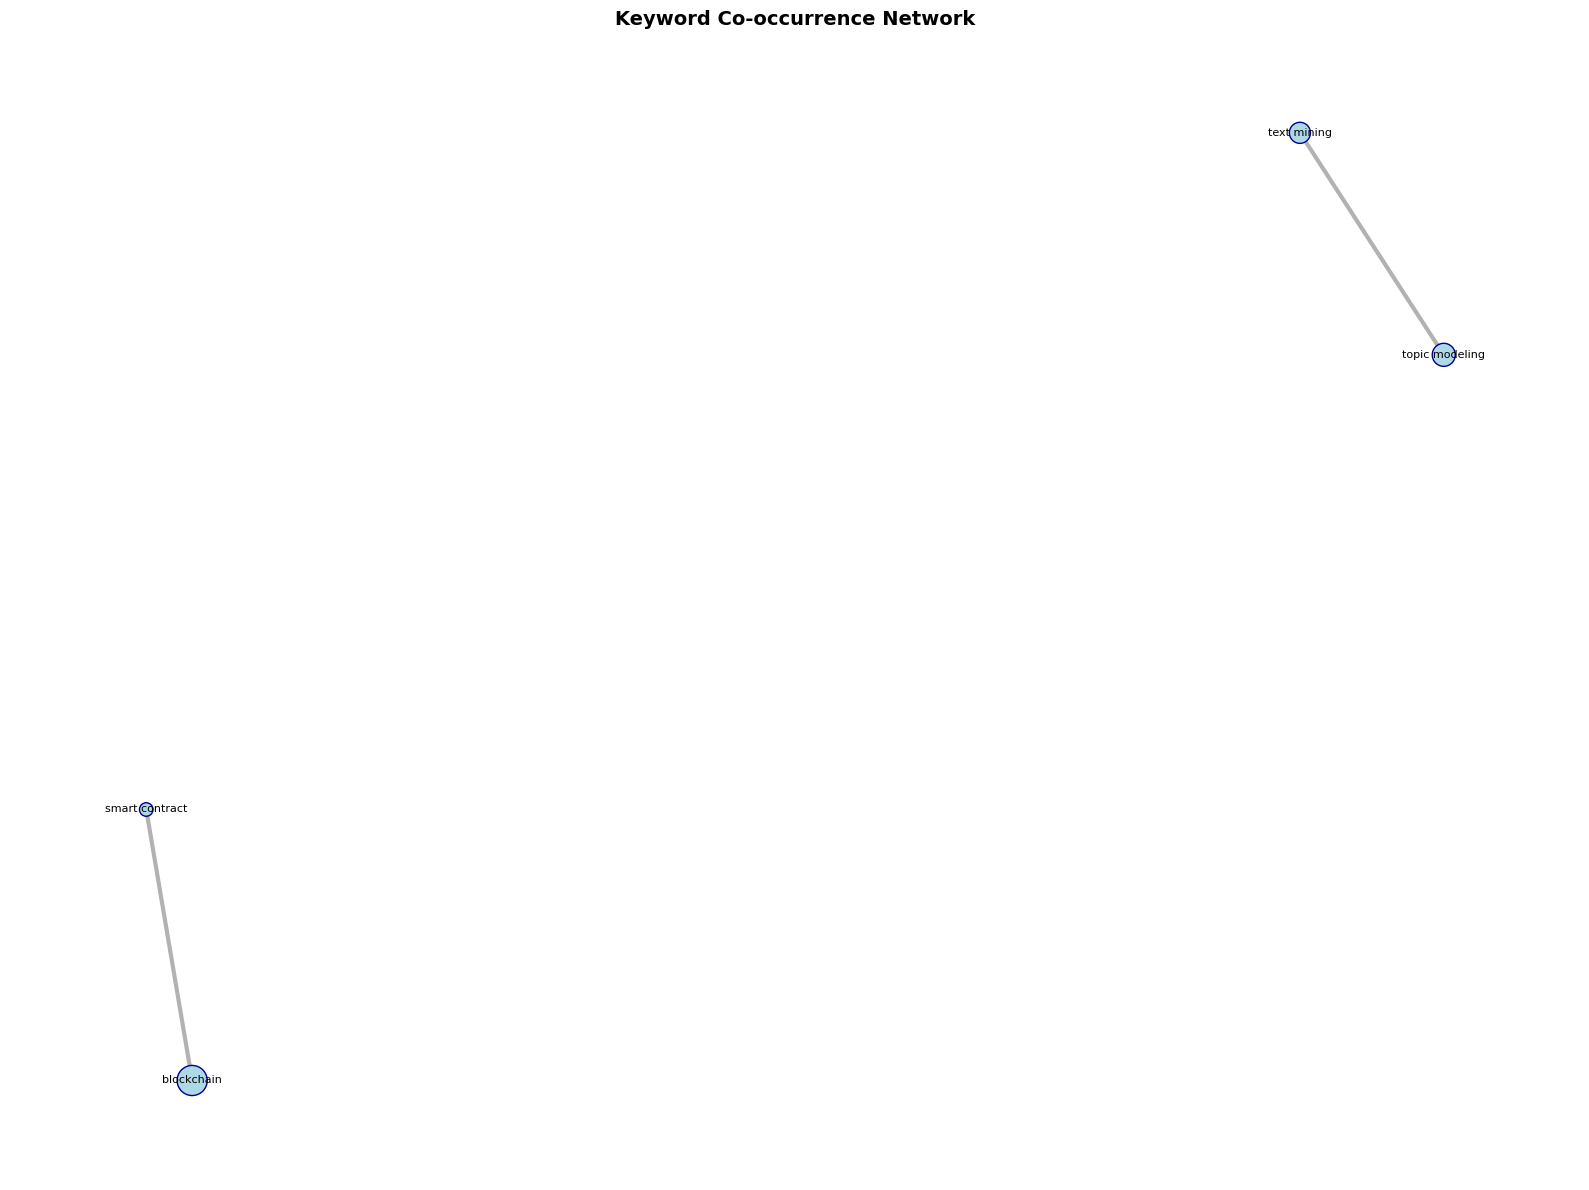

💾 저장: advanced_04_network.png


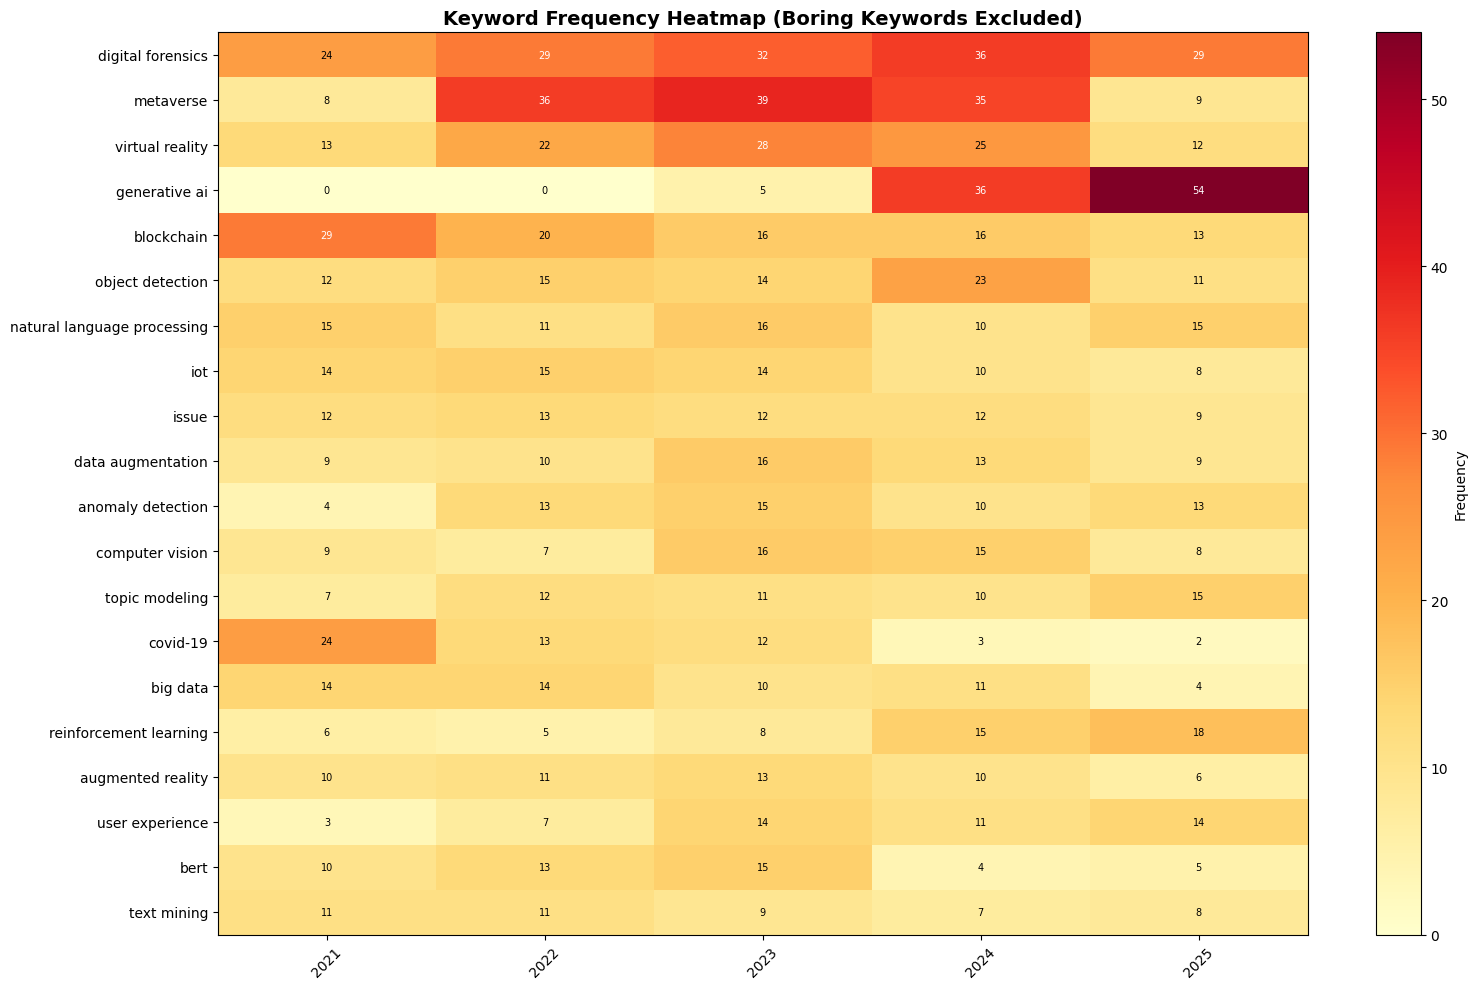

💾 저장: advanced_05_heatmap.png

💾 결과 저장
✅ signature_keywords_by_year.csv
✅ emerging_keywords_prediction.csv
✅ keyword_lifecycle.csv

✅ 모든 고급 분석 완료!

📁 생성된 파일:
   - advanced_01_domain_trends.png (도메인별 트렌드)
   - advanced_02_domain_share.png (도메인 점유율 변화)
   - advanced_03_bubble_chart.png (성장률 vs 빈도 버블)
   - advanced_04_network.png (키워드 네트워크)
   - advanced_05_heatmap.png (연도별 히트맵)
   - signature_keywords_by_year.csv (연도별 대표 키워드)
   - emerging_keywords_prediction.csv (떠오르는 키워드)
   - keyword_lifecycle.csv (키워드 생애주기)


In [ ]:
# ============================================
# Google Colab용 - 고급 키워드 트렌드 분석
# 뻔한 키워드 제외 + 신박한 분석
# ============================================

# %% [2] 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# %% [3] 데이터 로드
print("📂 데이터 로딩 중...")
df = pd.read_csv('/content/drive/MyDrive/datathon/데이터/데이터/컴퓨터학_최종키워드.csv', encoding='utf-8')
print(f"✅ 전체 논문 수: {len(df):,}개")

# 전처리
df['PBSH'] = df['PBSH'].astype(str)
df['YEAR'] = df['PBSH'].str[:4].astype(int)
df['MONTH'] = df['PBSH'].str[4:6].astype(int)
df['QUARTER'] = ((df['MONTH'] - 1) // 3) + 1
df['YEAR_Q'] = df['YEAR'].astype(str) + '-Q' + df['QUARTER'].astype(str)

def parse_keywords(kw_str):
    if pd.isna(kw_str) or kw_str == '':
        return []
    return [k.strip().lower() for k in str(kw_str).split(',') if k.strip()]

df['KEYWORD_LIST'] = df['최종 키워드'].apply(parse_keywords)

# %% [4] 🚫 뻔한 키워드 제외 리스트
BORING_KEYWORDS = {
    # 일반적인 ML/AI 키워드
    'deep learning', 'machine learning', 'artificial intelligence', 'neural network',
    'neural networks', 'convolutional neural network', 'cnn', 'rnn', 'lstm',
    'classification', 'prediction', 'model', 'algorithm', 'data', 'system',
    'network', 'learning', 'training', 'performance', 'analysis', 'method',
    'approach', 'framework', 'application', 'based', 'using', 'study',
    # 너무 일반적인 단어
    'image', 'video', 'text', 'feature', 'detection', 'recognition',
    'processing', 'information', 'research', 'paper', 'proposed',
}

def filter_boring(keywords):
    """뻔한 키워드 제거"""
    return [kw for kw in keywords if kw not in BORING_KEYWORDS and len(kw) > 2]

df['FILTERED_KEYWORDS'] = df['KEYWORD_LIST'].apply(filter_boring)

# %% [5] 연도별 키워드 빈도 (필터링된)
yearly_keywords = {}
for year in sorted(df['YEAR'].unique()):
    year_df = df[df['YEAR'] == year]
    year_kw = []
    for kw_list in year_df['FILTERED_KEYWORDS']:
        year_kw.extend(kw_list)
    yearly_keywords[year] = Counter(year_kw)

all_filtered = []
for kw_list in df['FILTERED_KEYWORDS']:
    all_filtered.extend(kw_list)
filtered_counter = Counter(all_filtered)

print(f"\n📊 데이터 기간: {df['YEAR'].min()} ~ {df['YEAR'].max()}")
print(f"📊 뻔한 키워드 제외 후 TOP 20:")
for i, (kw, count) in enumerate(filtered_counter.most_common(20), 1):
    print(f"   {i:2}. {kw}: {count:,}회")

# %% [6] 🔥 버스트 감지 (Burst Detection) - 갑자기 폭발한 키워드
print("\n" + "=" * 70)
print("🔥 버스트 감지 - 갑자기 폭발적으로 증가한 키워드")
print("=" * 70)

def detect_bursts(yearly_keywords, min_count=5):
    """연도별 버스트 감지 - 전년 대비 급증한 키워드"""
    years = sorted(yearly_keywords.keys())
    bursts = {}

    for i, year in enumerate(years[1:], 1):
        prev_year = years[i-1]
        year_bursts = []

        for kw in yearly_keywords[year]:
            curr = yearly_keywords[year][kw]
            prev = yearly_keywords[prev_year].get(kw, 0)

            if curr >= min_count:
                if prev == 0:
                    # 새로 등장해서 급증
                    if curr >= 10:
                        year_bursts.append((kw, curr, prev, float('inf')))
                elif curr >= prev * 2:  # 2배 이상 증가
                    growth = (curr - prev) / prev * 100
                    year_bursts.append((kw, curr, prev, growth))

        year_bursts.sort(key=lambda x: x[1], reverse=True)
        bursts[year] = year_bursts[:10]

    return bursts

bursts = detect_bursts(yearly_keywords, min_count=5)

for year in sorted(bursts.keys())[-5:]:  # 최근 5년만
    print(f"\n🗓️ {year}년 버스트 키워드:")
    for kw, curr, prev, growth in bursts[year][:5]:
        if growth == float('inf'):
            print(f"   🆕 {kw}: {curr}회 (신규 등장!)")
        else:
            print(f"   📈 {kw}: {prev} → {curr}회 (+{growth:.0f}%)")

# %% [7] 📊 연도별 대표 키워드 (그 해를 정의하는 키워드)
print("\n" + "=" * 70)
print("📊 연도별 대표 키워드 - 각 연도를 정의하는 키워드")
print("=" * 70)

def get_year_signature_keywords(yearly_keywords, top_n=5):
    """TF-IDF 방식으로 각 연도의 특징적 키워드 추출"""
    years = sorted(yearly_keywords.keys())

    # 전체 키워드 수집
    all_kw = set()
    for counter in yearly_keywords.values():
        all_kw.update(counter.keys())

    # IDF 계산 (몇 개 연도에 등장했는지)
    idf = {}
    for kw in all_kw:
        doc_count = sum(1 for y in years if yearly_keywords[y].get(kw, 0) > 0)
        idf[kw] = np.log(len(years) / (1 + doc_count))

    # 각 연도별 TF-IDF
    signature = {}
    for year in years:
        total = sum(yearly_keywords[year].values())
        if total == 0:
            continue

        tfidf_scores = []
        for kw, count in yearly_keywords[year].items():
            tf = count / total
            score = tf * idf[kw] * count  # count도 가중치로
            tfidf_scores.append((kw, score, count))

        tfidf_scores.sort(key=lambda x: x[1], reverse=True)
        signature[year] = tfidf_scores[:top_n]

    return signature

signatures = get_year_signature_keywords(yearly_keywords, top_n=7)

for year in sorted(signatures.keys()):
    kws = [f"{kw}({cnt})" for kw, _, cnt in signatures[year]]
    print(f"📅 {year}년: {', '.join(kws)}")

# %% [8] 🕸️ 키워드 동시출현 네트워크 분석
print("\n" + "=" * 70)
print("🕸️ 키워드 동시출현 분석 - 함께 연구되는 키워드")
print("=" * 70)

def get_cooccurrence(df, min_cooccur=10):
    """키워드 동시출현 빈도 계산"""
    cooccur = defaultdict(int)

    for kw_list in df['FILTERED_KEYWORDS']:
        if len(kw_list) >= 2:
            for kw1, kw2 in combinations(sorted(set(kw_list)), 2):
                cooccur[(kw1, kw2)] += 1

    # 최소 빈도 이상만
    filtered = {k: v for k, v in cooccur.items() if v >= min_cooccur}
    return filtered

cooccurrence = get_cooccurrence(df, min_cooccur=15)

print("\n🔗 자주 함께 등장하는 키워드 쌍 TOP 20:")
sorted_cooccur = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)[:20]
for i, ((kw1, kw2), count) in enumerate(sorted_cooccur, 1):
    print(f"   {i:2}. {kw1} ↔ {kw2}: {count}회")

# %% [9] 📈 키워드 생애주기 분석 (Lifecycle)
print("\n" + "=" * 70)
print("📈 키워드 생애주기 분석")
print("=" * 70)

def analyze_keyword_lifecycle(yearly_keywords, min_total=20):
    """키워드의 생애주기 분석"""
    years = sorted(yearly_keywords.keys())

    all_kw = set()
    for counter in yearly_keywords.values():
        all_kw.update(counter.keys())

    lifecycle = {}
    for kw in all_kw:
        counts = [yearly_keywords[y].get(kw, 0) for y in years]
        total = sum(counts)

        if total < min_total:
            continue

        # 첫 등장, 피크, 마지막 등장
        first_year = next((y for y, c in zip(years, counts) if c > 0), None)
        last_year = next((y for y, c in zip(reversed(years), reversed(counts)) if c > 0), None)
        peak_idx = np.argmax(counts)
        peak_year = years[peak_idx]
        peak_count = counts[peak_idx]

        # 현재 상태 판단
        recent_avg = np.mean(counts[-2:]) if len(counts) >= 2 else counts[-1]
        early_avg = np.mean(counts[:2]) if len(counts) >= 2 else counts[0]
        peak_avg = peak_count

        if recent_avg >= peak_avg * 0.8:
            status = "🔥 Hot (정점)"
        elif recent_avg >= early_avg:
            status = "📈 Rising (성장)"
        elif recent_avg < peak_avg * 0.3:
            status = "📉 Declining (쇠퇴)"
        else:
            status = "➡️ Stable (안정)"

        lifecycle[kw] = {
            'first': first_year,
            'peak': peak_year,
            'peak_count': peak_count,
            'last': last_year,
            'total': total,
            'status': status,
            'counts': counts
        }

    return lifecycle

lifecycle = analyze_keyword_lifecycle(yearly_keywords, min_total=30)

# 상태별 분류
status_groups = defaultdict(list)
for kw, data in lifecycle.items():
    status_groups[data['status']].append((kw, data))

for status in ["🔥 Hot (정점)", "📈 Rising (성장)", "📉 Declining (쇠퇴)", "➡️ Stable (안정)"]:
    print(f"\n{status}:")
    items = sorted(status_groups[status], key=lambda x: x[1]['total'], reverse=True)[:7]
    for kw, data in items:
        print(f"   {kw}: {data['first']}~{data['last']}, 피크 {data['peak']}({data['peak_count']}회), 총 {data['total']}회")

# %% [10] 🎯 도메인별 트렌드 분석
print("\n" + "=" * 70)
print("🎯 도메인별 트렌드 분석")
print("=" * 70)

# 도메인 키워드 매핑
DOMAIN_KEYWORDS = {
    '🔐 보안/암호': ['security', 'privacy', 'encryption', 'authentication', 'blockchain',
                    'cyber', 'intrusion', 'malware', 'attack', 'vulnerability', 'cryptography'],
    '🤖 자연어처리': ['nlp', 'natural language', 'text mining', 'sentiment', 'transformer',
                     'bert', 'gpt', 'language model', 'chatbot', 'translation', 'summarization'],
    '👁️ 컴퓨터비전': ['object detection', 'segmentation', 'face', 'pose estimation',
                      'autonomous', 'lidar', 'point cloud', 'depth', '3d', 'gan'],
    '☁️ 클라우드/분산': ['cloud', 'edge', 'fog', 'distributed', 'container', 'kubernetes',
                        'microservice', 'serverless', 'scalability'],
    '📱 IoT/임베디드': ['iot', 'sensor', 'embedded', 'smart', 'wearable', 'arduino',
                       'raspberry', 'mqtt', 'lpwan', 'lora'],
    '🎮 메타버스/XR': ['metaverse', 'virtual reality', 'vr', 'ar', 'augmented reality',
                      'mixed reality', 'xr', 'avatar', 'digital twin'],
    '⚡ 최적화/효율': ['optimization', 'compression', 'pruning', 'quantization',
                      'lightweight', 'efficient', 'acceleration', 'edge computing'],
    '🏥 헬스케어': ['medical', 'healthcare', 'diagnosis', 'clinical', 'ecg', 'eeg',
                   'cancer', 'covid', 'patient', 'drug'],
}

def categorize_keywords(kw_list, domain_keywords):
    """키워드를 도메인별로 분류"""
    result = defaultdict(int)
    for kw in kw_list:
        for domain, keywords in domain_keywords.items():
            if any(dk in kw for dk in keywords):
                result[domain] += 1
                break
    return result

# 연도별 도메인 트렌드
domain_yearly = defaultdict(lambda: defaultdict(int))
for year in sorted(df['YEAR'].unique()):
    year_df = df[df['YEAR'] == year]
    for kw_list in year_df['KEYWORD_LIST']:
        domain_counts = categorize_keywords(kw_list, DOMAIN_KEYWORDS)
        for domain, count in domain_counts.items():
            domain_yearly[year][domain] += count

# 시각화: 도메인별 트렌드
fig, ax = plt.subplots(figsize=(14, 8))
years = sorted(domain_yearly.keys())
domains = list(DOMAIN_KEYWORDS.keys())

for domain in domains:
    counts = [domain_yearly[y][domain] for y in years]
    ax.plot(years, counts, marker='o', linewidth=2, markersize=6, label=domain)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Keyword Frequency', fontsize=12)
ax.set_title('Research Domain Trends Over Years', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('advanced_01_domain_trends.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 저장: advanced_01_domain_trends.png")

# %% [11] 📊 도메인 점유율 변화 (Stacked Area)
fig, ax = plt.subplots(figsize=(14, 8))

# 데이터 준비
domain_data = {d: [domain_yearly[y][d] for y in years] for d in domains}
domain_df = pd.DataFrame(domain_data, index=years)

# 비율로 변환
domain_pct = domain_df.div(domain_df.sum(axis=1), axis=0) * 100

# Stacked Area Chart
ax.stackplot(years, [domain_pct[d] for d in domains], labels=domains, alpha=0.8)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Share (%)', fontsize=12)
ax.set_title('Research Domain Share Over Years', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.savefig('advanced_02_domain_share.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 저장: advanced_02_domain_share.png")

# %% [12] 🆕 연도별 "이 해의 키워드" 발굴
print("\n" + "=" * 70)
print("🆕 연도별 '이 해의 키워드' - 그 해 처음 주목받은 키워드")
print("=" * 70)

appeared = set()
year_of_keywords = {}

for year in sorted(yearly_keywords.keys()):
    new_this_year = []
    for kw, count in yearly_keywords[year].most_common():
        if kw not in appeared and count >= 5:
            new_this_year.append((kw, count))
            year_of_keywords[kw] = year
        appeared.add(kw)

    if new_this_year[:5]:
        print(f"\n🗓️ {year}년 첫 등장 주요 키워드:")
        for kw, count in new_this_year[:5]:
            print(f"   ⭐ {kw} ({count}회)")

# %% [13] 🔮 미래 예측 - 다음에 뜰 키워드
print("\n" + "=" * 70)
print("🔮 다음에 뜰 키워드 예측 (최근 급성장 + 아직 소수)")
print("=" * 70)

years = sorted(yearly_keywords.keys())
recent_years = years[-2:]

future_candidates = []
for kw in filtered_counter:
    recent = sum(yearly_keywords[y].get(kw, 0) for y in recent_years)
    total = filtered_counter[kw]

    # 조건: 최근 2년에 집중 (70% 이상) + 전체 빈도 적당 (10~50)
    if total >= 10 and total <= 100:
        recent_ratio = recent / total if total > 0 else 0
        if recent_ratio >= 0.6:  # 최근 2년에 60% 이상
            future_candidates.append((kw, total, recent, recent_ratio))

future_candidates.sort(key=lambda x: (x[3], x[1]), reverse=True)

print("\n🚀 주목해야 할 떠오르는 키워드:")
for i, (kw, total, recent, ratio) in enumerate(future_candidates[:15], 1):
    print(f"   {i:2}. {kw}: 총 {total}회 (최근 {recent}회, {ratio*100:.0f}%)")

# %% [14] 📊 버블 차트 - 키워드 성장률 vs 빈도
fig, ax = plt.subplots(figsize=(14, 10))

# 성장률 계산
growth_data = []
for kw in filtered_counter:
    if filtered_counter[kw] >= 20:
        recent = sum(yearly_keywords[y].get(kw, 0) for y in years[-2:])
        early = sum(yearly_keywords[y].get(kw, 0) for y in years[:2])

        if early > 0:
            growth = (recent - early) / early * 100
        else:
            growth = recent * 50 if recent > 0 else 0

        growth_data.append({
            'keyword': kw,
            'total': filtered_counter[kw],
            'growth': growth,
            'recent': recent
        })

growth_df = pd.DataFrame(growth_data)

# 색상: 성장률 기준
colors = growth_df['growth'].apply(lambda x: 'green' if x > 50 else ('red' if x < -20 else 'blue'))
sizes = growth_df['total'] * 3

scatter = ax.scatter(growth_df['growth'], growth_df['total'],
                     s=sizes, c=colors, alpha=0.6, edgecolors='black')

# 상위 키워드 레이블
for _, row in growth_df.nlargest(15, 'total').iterrows():
    ax.annotate(row['keyword'], (row['growth'], row['total']),
                fontsize=8, alpha=0.8)

ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Growth Rate (%)', fontsize=12)
ax.set_ylabel('Total Frequency', fontsize=12)
ax.set_title('Keyword Growth vs Frequency (Green=Growing, Red=Declining)',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('advanced_03_bubble_chart.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 저장: advanced_03_bubble_chart.png")

# %% [15] 🕸️ 키워드 네트워크 시각화
try:
    import networkx as nx

    # 네트워크 생성
    G = nx.Graph()

    # 상위 동시출현 쌍 추가
    top_cooccur = sorted(cooccurrence.items(), key=lambda x: x[1], reverse=True)[:50]

    for (kw1, kw2), weight in top_cooccur:
        G.add_edge(kw1, kw2, weight=weight)

    # 노드 크기 = 키워드 빈도
    node_sizes = [filtered_counter.get(node, 10) * 5 for node in G.nodes()]

    fig, ax = plt.subplots(figsize=(16, 12))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

    # 엣지 굵기 = 동시출현 빈도
    edge_weights = [G[u][v]['weight'] / 5 for u, v in G.edges()]

    nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_weights, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue',
                           edgecolors='darkblue', linewidths=1, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    ax.set_title('Keyword Co-occurrence Network', fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('advanced_04_network.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("💾 저장: advanced_04_network.png")

except ImportError:
    print("⚠️ networkx 설치 필요: pip install networkx")

# %% [16] 📊 히트맵 - 연도별 TOP 키워드 (뻔한 것 제외)
fig, ax = plt.subplots(figsize=(16, 10))

# TOP 20 키워드 (뻔한 것 제외)
top_20 = [kw for kw, _ in filtered_counter.most_common(20)]
years = sorted(yearly_keywords.keys())

heatmap_data = []
for kw in top_20:
    row = [yearly_keywords[y].get(kw, 0) for y in years]
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, index=top_20, columns=years)

im = ax.imshow(heatmap_df.values, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(len(years)))
ax.set_xticklabels(years, rotation=45)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20)

for i in range(len(top_20)):
    for j in range(len(years)):
        val = heatmap_df.values[i, j]
        color = 'white' if val > heatmap_df.values.max() * 0.5 else 'black'
        ax.text(j, i, int(val), ha='center', va='center', color=color, fontsize=7)

ax.set_title('Keyword Frequency Heatmap (Boring Keywords Excluded)',
             fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Frequency')
plt.tight_layout()
plt.savefig('advanced_05_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 저장: advanced_05_heatmap.png")

# %% [17] 결과 저장
print("\n" + "=" * 70)
print("💾 결과 저장")
print("=" * 70)

# 연도별 대표 키워드
sig_data = []
for year, kws in signatures.items():
    for kw, score, count in kws:
        sig_data.append({'연도': year, '키워드': kw, '점수': round(score, 4), '빈도': count})
sig_df = pd.DataFrame(sig_data)
sig_df.to_csv('signature_keywords_by_year.csv', index=False, encoding='utf-8-sig')
print("✅ signature_keywords_by_year.csv")

# 떠오르는 키워드
future_df = pd.DataFrame(future_candidates, columns=['키워드', '총빈도', '최근빈도', '최근비율'])
future_df.to_csv('emerging_keywords_prediction.csv', index=False, encoding='utf-8-sig')
print("✅ emerging_keywords_prediction.csv")

# 키워드 생애주기
lifecycle_data = []
for kw, data in lifecycle.items():
    lifecycle_data.append({
        '키워드': kw, '첫등장': data['first'], '피크연도': data['peak'],
        '피크빈도': data['peak_count'], '총빈도': data['total'], '상태': data['status']
    })
lifecycle_df = pd.DataFrame(lifecycle_data)
lifecycle_df.to_csv('keyword_lifecycle.csv', index=False, encoding='utf-8-sig')
print("✅ keyword_lifecycle.csv")

print("\n✅ 모든 고급 분석 완료!")
print("\n📁 생성된 파일:")
print("   - advanced_01_domain_trends.png (도메인별 트렌드)")
print("   - advanced_02_domain_share.png (도메인 점유율 변화)")
print("   - advanced_03_bubble_chart.png (성장률 vs 빈도 버블)")
print("   - advanced_04_network.png (키워드 네트워크)")
print("   - advanced_05_heatmap.png (연도별 히트맵)")
print("   - signature_keywords_by_year.csv (연도별 대표 키워드)")
print("   - emerging_keywords_prediction.csv (떠오르는 키워드)")
print("   - keyword_lifecycle.csv (키워드 생애주기)")



In [ ]:
# 셀 1: 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

📂 데이터 로딩 중...
✅ 전체 논문 수: 6,086개

🔄 키워드 분류 중...

📊 분류 결과 통계

📈 주분류별 논문 수:
   5. HCI & Graphics: 1,902개 (31.3%) ███████████████
   1. AI & Data Science: 1,824개 (30.0%) ██████████████
   3. Software Engineering: 791개 (13.0%) ██████
   2. Network & IoT: 653개 (10.7%) █████
   4. Cybersecurity: 607개 (10.0%) ████
   Unclassified: 309개 (5.1%) ██

📅 연도별 분류 추이
주분류   1. AI & Data Science  2. Network & IoT  3. Software Engineering  \
YEAR                                                                    
2021                   362               142                      156   
2022                   324               141                      151   
2023                   358               147                      164   
2024                   414               128                      176   
2025                   366                95                      144   

주분류   4. Cybersecurity  5. HCI & Graphics  Unclassified  
YEAR                                                     
2021               

/tmp/ipython-input-1119514329.py:259: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1119514329.py:260: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.savefig('category_01_distribution.png', dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


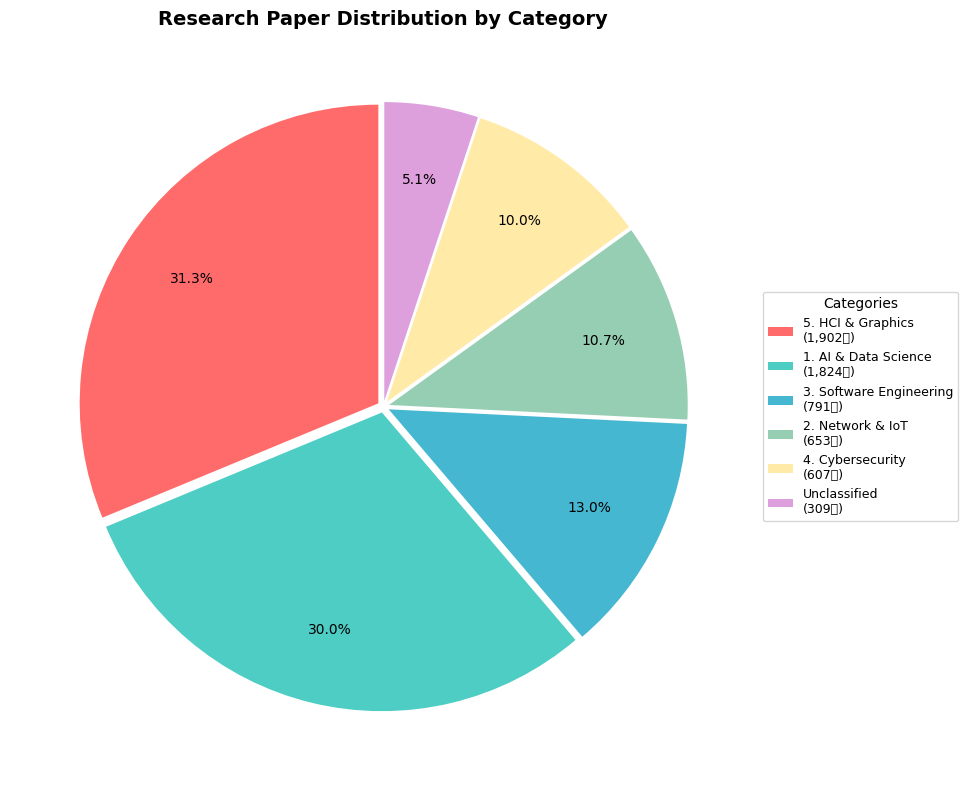

💾 저장: category_01_distribution.png


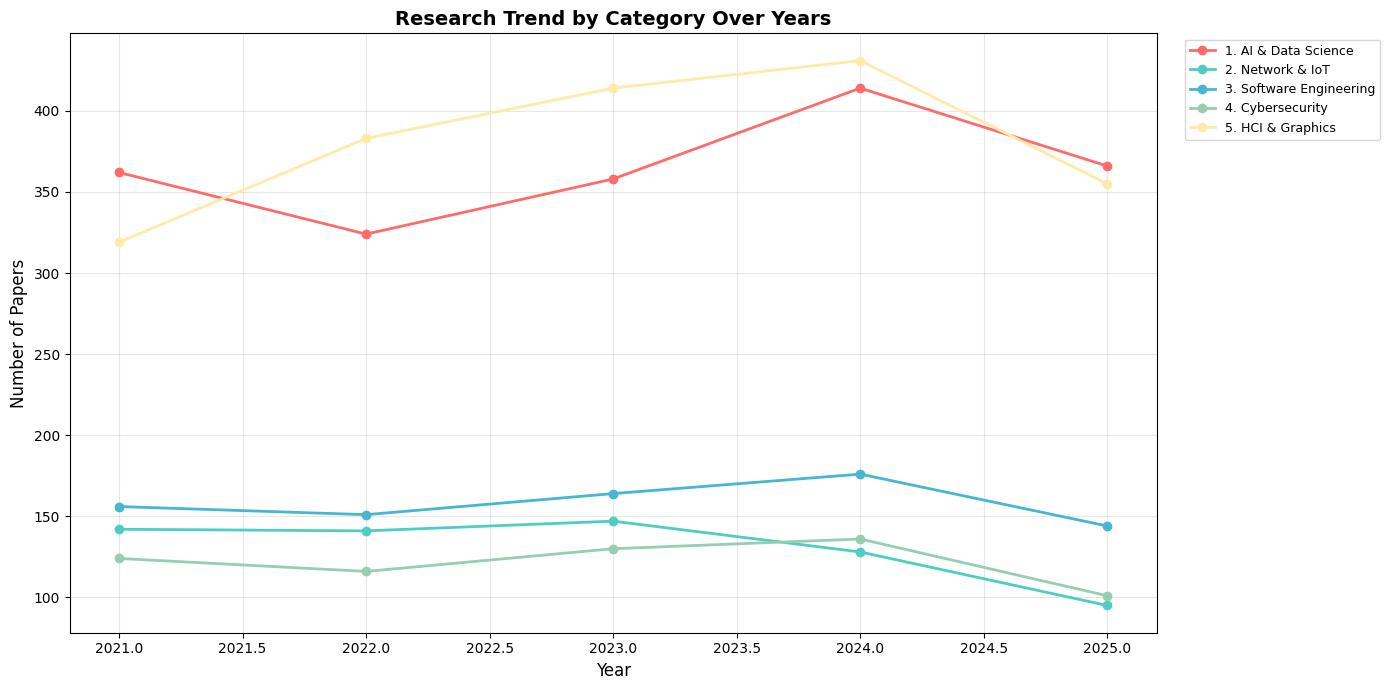

💾 저장: category_02_yearly_trend.png


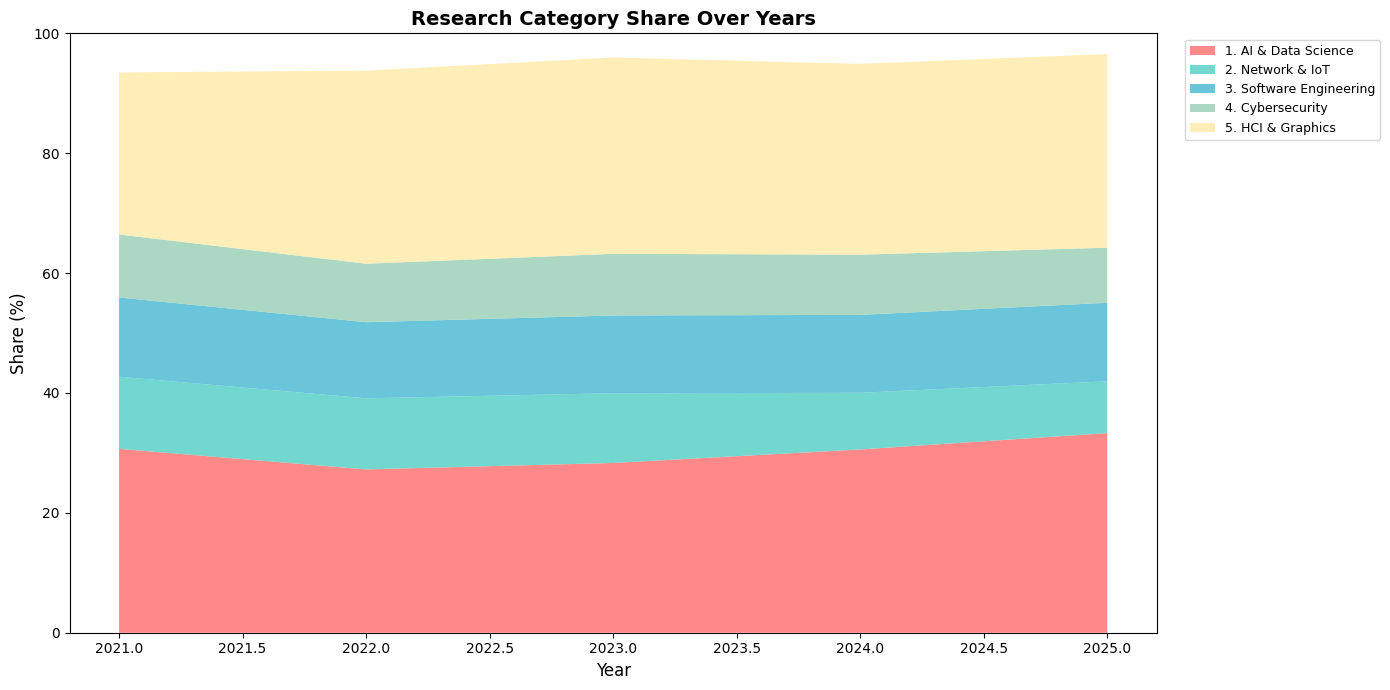

💾 저장: category_03_yearly_share.png


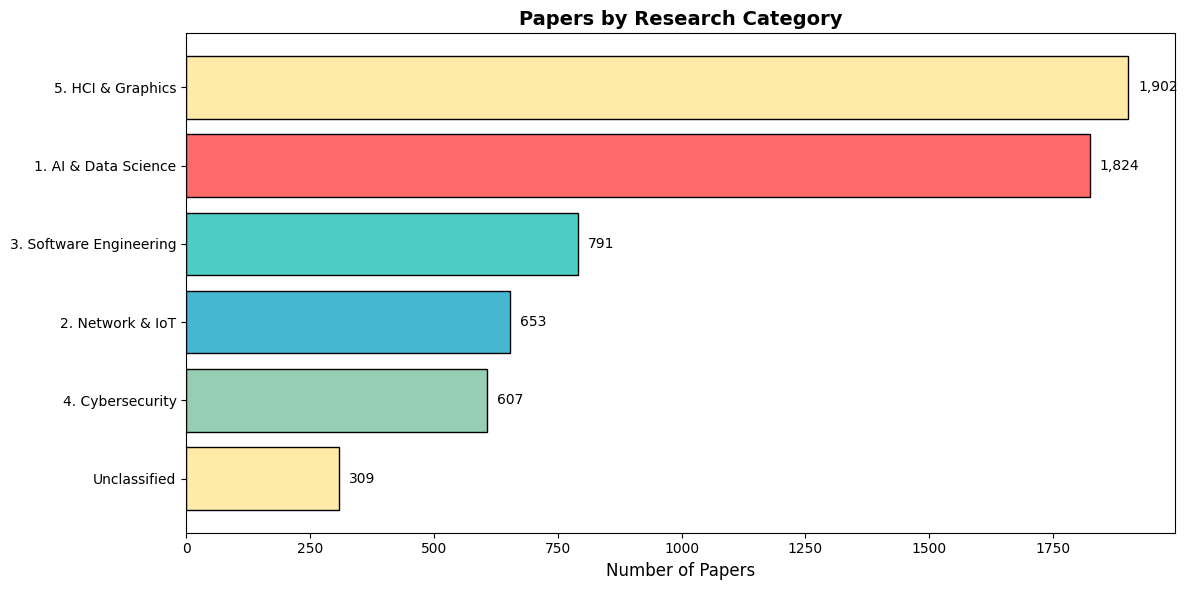

💾 저장: category_04_bar_chart.png

📊 카테고리별 TOP 10 키워드

🏷️ 1. AI & Data Science (논문 1,824개)
    1. deep learning: 319회
    2. machine learning: 135회
    3. artificial intelligence: 105회
    4. generative ai: 72회
    5. ai: 64회
    6. object detection: 62회
    7. natural language processing: 58회
    8. anomaly detection: 48회
    9. computer vision: 45회
   10. cnn: 44회

🏷️ 2. Network & IoT (논문 653개)
    1. iot: 41회
    2. drone: 19회
    3. machine learning: 17회
    4. cloud computing: 15회
    5. autonomous driving: 15회
    6. deep learning: 13회
    7. edge computing: 13회
    8. 5g: 12회
    9. internet of things: 10회
   10. raspberry pi: 10회

🏷️ 3. Software Engineering (논문 791개)
    1. digital forensics: 72회
    2. digital literacy: 14회
    3. digital transformation: 14회
    4. digital twin: 13회
    5. static analysis: 13회
    6. android: 12회
    7. webtoon: 12회
    8. digital evidence: 11회
    9. education: 10회
   10. platform: 10회

🏷️ 4. Cybersecurity (논문 607개)
    1. digital forensics: 54

In [ ]:
CATEGORY_KEYWORDS = {
    '1. AI & Data Science': [
        # 머신러닝/딥러닝
        'machine learning', 'deep learning', 'neural network', 'artificial intelligence',
        'ai', '머신러닝', '딥러닝', '인공지능', '기계학습', '신경망',
        'cnn', 'rnn', 'lstm', 'gan', 'transformer', 'attention',
        'convolutional', 'recurrent', 'autoencoder', 'encoder', 'decoder',
        # NLP
        'nlp', 'natural language', '자연어', 'text mining', 'sentiment',
        'bert', 'gpt', 'language model', 'word embedding', 'tokenization',
        'named entity', 'ner', 'pos tagging', 'machine translation', '번역',
        'question answering', 'chatbot', '챗봇', 'dialogue', 'summarization',
        # 컴퓨터 비전
        'computer vision', 'image', 'object detection', 'segmentation',
        'face recognition', 'pose estimation', 'ocr', 'feature extraction',
        '객체 탐지', '영상', '이미지', '객체 인식', '얼굴 인식',
        # 데이터 사이언스
        'data science', 'data mining', 'big data', 'analytics', 'prediction',
        'classification', 'clustering', 'regression', 'recommendation',
        '빅데이터', '데이터 분석', '예측', '분류', '추천',
        # 강화학습
        'reinforcement learning', '강화학습', 'q-learning', 'policy',
        # 최적화
        'optimization', 'genetic algorithm', 'swarm', 'evolutionary',
        # 통계/수학
        'bayesian', 'probabilistic', 'statistical', 'markov',
        # 특수 기법
        'transfer learning', 'federated learning', 'few-shot', 'zero-shot',
        'explainable', 'xai', 'knowledge graph', 'ontology',
        'anomaly detection', '이상 탐지', 'time series', '시계열',
    ],

    '2. Network & IoT': [
        # 네트워크
        'network', 'networking', '네트워크', 'protocol', '프로토콜',
        'tcp', 'udp', 'ip', 'routing', 'switching', 'topology',
        'wireless', '무선', 'wifi', 'bluetooth', '블루투스',
        '5g', '6g', 'lte', 'cellular', 'mobile network',
        'sdn', 'nfv', 'software defined', 'load balancing',
        'qos', 'latency', 'bandwidth', 'throughput',
        # IoT
        'iot', 'internet of things', '사물인터넷', 'sensor', '센서',
        'embedded', '임베디드', 'arduino', 'raspberry', 'microcontroller',
        'mqtt', 'coap', 'lpwan', 'lora', 'zigbee', 'rfid', 'nfc',
        'smart home', '스마트홈', 'smart city', '스마트시티',
        'smart farm', '스마트팜', 'smart factory', '스마트공장',
        'wearable', '웨어러블', 'healthcare iot', 'industrial iot',
        # 클라우드/분산
        'cloud', '클라우드', 'edge computing', '엣지', 'fog computing',
        'distributed', '분산', 'cluster', 'container', 'docker', 'kubernetes',
        'microservice', 'serverless', 'virtualization', '가상화',
        # 자율주행/로봇
        'autonomous', '자율주행', 'robot', '로봇', 'drone', '드론',
        'lidar', 'radar', 'v2x', 'vehicle', 'navigation',
        # 통신
        'communication', '통신', 'transmission', 'modulation',
        'antenna', 'signal processing', 'spectrum',
    ],

    '3. Software Engineering': [
        # 소프트웨어 개발
        'software engineering', '소프트웨어 공학', 'software development',
        'agile', 'scrum', 'devops', 'ci/cd', 'continuous integration',
        'version control', 'git', 'testing', '테스트', 'debugging',
        'code review', 'refactoring', 'design pattern', '디자인 패턴',
        # 프로그래밍
        'programming', '프로그래밍', 'algorithm', '알고리즘',
        'data structure', '자료구조', 'compiler', '컴파일러',
        'api', 'framework', '프레임워크', 'library', '라이브러리',
        'object oriented', '객체지향', 'functional programming',
        # 웹/앱
        'web', '웹', 'mobile app', '모바일 앱', 'android', 'ios',
        'frontend', 'backend', 'full stack', 'rest', 'graphql',
        'javascript', 'python', 'java', 'react', 'node',
        # 데이터베이스
        'database', '데이터베이스', 'sql', 'nosql', 'mongodb',
        'query', 'indexing', 'transaction', 'orm',
        # 시스템
        'operating system', '운영체제', 'kernel', 'memory management',
        'process', 'thread', 'scheduling', 'file system',
        # 품질/유지보수
        'quality assurance', 'qa', 'maintenance', '유지보수',
        'documentation', 'requirement', '요구사항', 'specification',
        # 형식 검증
        'formal verification', 'model checking', 'static analysis',
        'code analysis', 'bug detection', 'vulnerability',
    ],

    '4. Cybersecurity': [
        # 보안 일반
        'security', '보안', 'cybersecurity', '사이버보안',
        'information security', '정보보호', 'privacy', '프라이버시',
        'threat', '위협', 'risk', '위험', 'vulnerability', '취약점',
        # 암호
        'cryptography', '암호', 'encryption', '암호화', 'decryption',
        'hash', 'digital signature', '전자서명', 'pki', 'certificate',
        'aes', 'rsa', 'elliptic curve', 'homomorphic',
        # 인증/접근제어
        'authentication', '인증', 'authorization', '권한',
        'access control', '접근제어', 'biometric', '생체인식',
        'password', 'multi-factor', 'sso', 'oauth', 'identity',
        # 네트워크 보안
        'firewall', '방화벽', 'intrusion detection', '침입탐지',
        'ids', 'ips', 'vpn', 'ssl', 'tls', 'https',
        # 악성코드/공격
        'malware', '악성코드', 'ransomware', '랜섬웨어',
        'virus', 'trojan', 'worm', 'botnet', 'ddos', 'dos',
        'phishing', '피싱', 'attack', '공격', 'exploit',
        'reverse engineering', '역공학', 'forensic', '포렌식',
        # 블록체인
        'blockchain', '블록체인', 'smart contract', '스마트컨트랙트',
        'cryptocurrency', '암호화폐', 'bitcoin', 'ethereum', 'nft',
        'consensus', 'decentralized', 'distributed ledger',
        # 개인정보
        'gdpr', 'personal data', '개인정보', 'anonymization', '익명화',
        'differential privacy', 'data protection',
    ],

    '5. HCI & Graphics': [
        # HCI
        'hci', 'human computer interaction', '인간컴퓨터상호작용',
        'user experience', 'ux', '사용자 경험', 'user interface', 'ui',
        'usability', '사용성', 'accessibility', '접근성',
        'interaction design', '인터랙션', 'gesture', '제스처',
        'eye tracking', '시선추적', 'brain computer', 'bci',
        # 메타버스/XR
        'metaverse', '메타버스', 'virtual reality', 'vr', '가상현실',
        'augmented reality', 'ar', '증강현실', 'mixed reality', 'mr',
        'extended reality', 'xr', '확장현실',
        'avatar', '아바타', 'digital twin', '디지털트윈',
        'immersive', '몰입', 'haptic', '햅틱', '촉각',
        # 그래픽스
        'computer graphics', '컴퓨터그래픽스', '그래픽',
        '3d', 'rendering', '렌더링', 'visualization', '시각화',
        'animation', '애니메이션', 'modeling', '모델링',
        'texture', 'shader', 'ray tracing', 'opengl', 'vulkan',
        # 게임
        'game', '게임', 'game design', 'game development',
        'game engine', 'unity', 'unreal', 'npc', 'gameplay',
        'e-sports', '이스포츠', 'serious game',
        # 멀티미디어
        'multimedia', '멀티미디어', 'audio', '오디오', 'video', '비디오',
        'streaming', '스트리밍', 'codec', 'compression', '압축',
        'speech', '음성', 'voice', 'music', '음악',
        # 디자인
        'design', '디자인', 'creative', 'art', 'aesthetic',
        'content creation', '콘텐츠', 'digital content',
    ],
}

# %% [3] 분류 함수
def classify_keywords(keyword_str):
    """
    키워드 문자열을 5대 분류로 분류
    가장 많이 매칭되는 카테고리 반환
    """
    if pd.isna(keyword_str) or keyword_str == '':
        return 'Unclassified'

    keywords = [k.strip().lower() for k in str(keyword_str).split(',')]

    category_scores = defaultdict(int)
    matched_keywords = defaultdict(list)

    for kw in keywords:
        for category, cat_keywords in CATEGORY_KEYWORDS.items():
            for cat_kw in cat_keywords:
                if cat_kw in kw or kw in cat_kw:
                    category_scores[category] += 1
                    matched_keywords[category].append(kw)
                    break

    if not category_scores:
        return 'Unclassified'

    # 가장 높은 점수의 카테고리 반환
    best_category = max(category_scores, key=category_scores.get)
    return best_category

def get_all_categories(keyword_str):
    """
    키워드가 속하는 모든 카테고리 반환 (다중 분류)
    """
    if pd.isna(keyword_str) or keyword_str == '':
        return []

    keywords = [k.strip().lower() for k in str(keyword_str).split(',')]

    categories = set()
    for kw in keywords:
        for category, cat_keywords in CATEGORY_KEYWORDS.items():
            for cat_kw in cat_keywords:
                if cat_kw in kw or kw in cat_kw:
                    categories.add(category)
                    break

    return list(categories)

# %% [4] 데이터 로드 및 분류 적용
print("📂 데이터 로딩 중...")
df = pd.read_csv('/content/drive/MyDrive/datathon/데이터/데이터/컴퓨터학_최종키워드.csv', encoding='utf-8')
print(f"✅ 전체 논문 수: {len(df):,}개")

print("\n🔄 키워드 분류 중...")
df['주분류'] = df['최종 키워드'].apply(classify_keywords)
df['다중분류'] = df['최종 키워드'].apply(get_all_categories)
df['다중분류_str'] = df['다중분류'].apply(lambda x: ', '.join(x) if x else 'Unclassified')

# %% [5] 분류 결과 통계
print("\n" + "=" * 70)
print("📊 분류 결과 통계")
print("=" * 70)

category_counts = df['주분류'].value_counts()
total = len(df)

print("\n📈 주분류별 논문 수:")
for cat, count in category_counts.items():
    pct = count / total * 100
    bar = '█' * int(pct / 2)
    print(f"   {cat}: {count:,}개 ({pct:.1f}%) {bar}")

# %% [6] 연도별 분류 추이
df['YEAR'] = df['PBSH'].astype(str).str[:4].astype(int)

print("\n" + "=" * 70)
print("📅 연도별 분류 추이")
print("=" * 70)

yearly_category = df.groupby(['YEAR', '주분류']).size().unstack(fill_value=0)
print(yearly_category)

# %% [7] 시각화 1: 전체 분류 분포 (파이 차트)
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
explode = [0.02] * len(category_counts)

wedges, texts, autotexts = ax.pie(
    category_counts.values,
    labels=None,
    autopct='%1.1f%%',
    colors=colors[:len(category_counts)],
    explode=explode,
    startangle=90,
    pctdistance=0.75
)

ax.legend(
    wedges,
    [f"{cat}\n({count:,}개)" for cat, count in category_counts.items()],
    title="Categories",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=9
)

ax.set_title('Research Paper Distribution by Category', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('category_01_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 저장: category_01_distribution.png")

# %% [8] 시각화 2: 연도별 분류 추이 (라인 차트)
fig, ax = plt.subplots(figsize=(14, 7))

categories = [cat for cat in CATEGORY_KEYWORDS.keys()]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

for i, cat in enumerate(categories):
    if cat in yearly_category.columns:
        ax.plot(yearly_category.index, yearly_category[cat],
                marker='o', linewidth=2, markersize=6,
                label=cat, color=colors[i])

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Papers', fontsize=12)
ax.set_title('Research Trend by Category Over Years', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('category_02_yearly_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 저장: category_02_yearly_trend.png")

# %% [9] 시각화 3: 연도별 분류 비율 (Stacked Area)
fig, ax = plt.subplots(figsize=(14, 7))

# 비율로 변환
yearly_pct = yearly_category.div(yearly_category.sum(axis=1), axis=0) * 100

# 5대 분류만 선택
plot_categories = [cat for cat in categories if cat in yearly_pct.columns]
plot_data = [yearly_pct[cat] for cat in plot_categories]

ax.stackplot(yearly_pct.index, plot_data, labels=plot_categories,
             colors=colors[:len(plot_categories)], alpha=0.8)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Share (%)', fontsize=12)
ax.set_title('Research Category Share Over Years', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
ax.set_ylim(0, 100)
plt.tight_layout()
plt.savefig('category_03_yearly_share.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 저장: category_03_yearly_share.png")

# %% [10] 시각화 4: 분류별 막대 그래프
fig, ax = plt.subplots(figsize=(12, 6))

cats = list(category_counts.index)
counts = list(category_counts.values)

bars = ax.barh(cats[::-1], counts[::-1], color=colors[:len(cats)][::-1], edgecolor='black')

for bar, count in zip(bars, counts[::-1]):
    ax.text(bar.get_width() + 20, bar.get_y() + bar.get_height()/2,
            f'{count:,}', va='center', fontsize=10)

ax.set_xlabel('Number of Papers', fontsize=12)
ax.set_title('Papers by Research Category', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('category_04_bar_chart.png', dpi=150, bbox_inches='tight')
plt.show()
print("💾 저장: category_04_bar_chart.png")

# %% [11] 각 카테고리별 TOP 키워드
print("\n" + "=" * 70)
print("📊 카테고리별 TOP 10 키워드")
print("=" * 70)

for category in categories:
    cat_df = df[df['주분류'] == category]

    if len(cat_df) == 0:
        continue

    all_keywords = []
    for kw_str in cat_df['최종 키워드'].dropna():
        keywords = [k.strip().lower() for k in str(kw_str).split(',') if k.strip()]
        all_keywords.extend(keywords)

    counter = Counter(all_keywords)
    top_10 = counter.most_common(10)

    print(f"\n🏷️ {category} (논문 {len(cat_df):,}개)")
    for i, (kw, count) in enumerate(top_10, 1):
        print(f"   {i:2}. {kw}: {count}회")

# %% [12] 다중 분류 분석
print("\n" + "=" * 70)
print("🔀 다중 분류 분석 (여러 분야에 걸친 논문)")
print("=" * 70)

multi_category_count = df['다중분류'].apply(len)
print(f"\n1개 분야: {(multi_category_count == 1).sum():,}개")
print(f"2개 분야: {(multi_category_count == 2).sum():,}개")
print(f"3개 이상: {(multi_category_count >= 3).sum():,}개")
print(f"미분류: {(multi_category_count == 0).sum():,}개")

# 자주 겹치는 분야 조합
from itertools import combinations

pair_counts = defaultdict(int)
for cats in df['다중분류']:
    if len(cats) >= 2:
        for pair in combinations(sorted(cats), 2):
            pair_counts[pair] += 1

print("\n🔗 자주 겹치는 분야 조합:")
sorted_pairs = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10]
for (cat1, cat2), count in sorted_pairs:
    cat1_short = cat1.split('. ')[1] if '. ' in cat1 else cat1
    cat2_short = cat2.split('. ')[1] if '. ' in cat2 else cat2
    print(f"   {cat1_short} + {cat2_short}: {count}개")

# %% [13] 결과 저장
print("\n" + "=" * 70)
print("💾 결과 저장")
print("=" * 70)

# 분류 결과 CSV 저장
output_df = df[['IPRD_NM', 'PLCT_NM', 'NODE_TTLE', 'NODE_TTLE_EN', 'PBSH',
                'YEAR', '최종 키워드', '주분류', '다중분류_str']].copy()
output_df.to_csv('컴퓨터학_5대분류.csv', index=False, encoding='utf-8-sig')
print("✅ 컴퓨터학_5대분류.csv")

# 카테고리별 통계 CSV
stats_df = category_counts.reset_index()
stats_df.columns = ['카테고리', '논문수']
stats_df['비율(%)'] = (stats_df['논문수'] / total * 100).round(1)
stats_df.to_csv('category_statistics.csv', index=False, encoding='utf-8-sig')
print("✅ category_statistics.csv")

# 연도별 카테고리 CSV
yearly_category.to_csv('yearly_category_counts.csv', encoding='utf-8-sig')
print("✅ yearly_category_counts.csv")

print("\n✅ 모든 분류 완료!")
print("\n📁 생성된 파일:")
print("   - 컴퓨터학_5대분류.csv (분류 결과)")
print("   - category_statistics.csv (카테고리별 통계)")
print("   - yearly_category_counts.csv (연도별 카테고리)")
print("   - category_01_distribution.png (파이 차트)")
print("   - category_02_yearly_trend.png (연도별 추이)")
print("   - category_03_yearly_share.png (연도별 비율)")
print("   - category_04_bar_chart.png (막대 그래프)")